Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: colorspace

Loading required package: khroma

Loading required package: ggplot2

Loading required package: ggpattern

Loading required package: reshape2

Loading required package: tidyverse

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all 

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

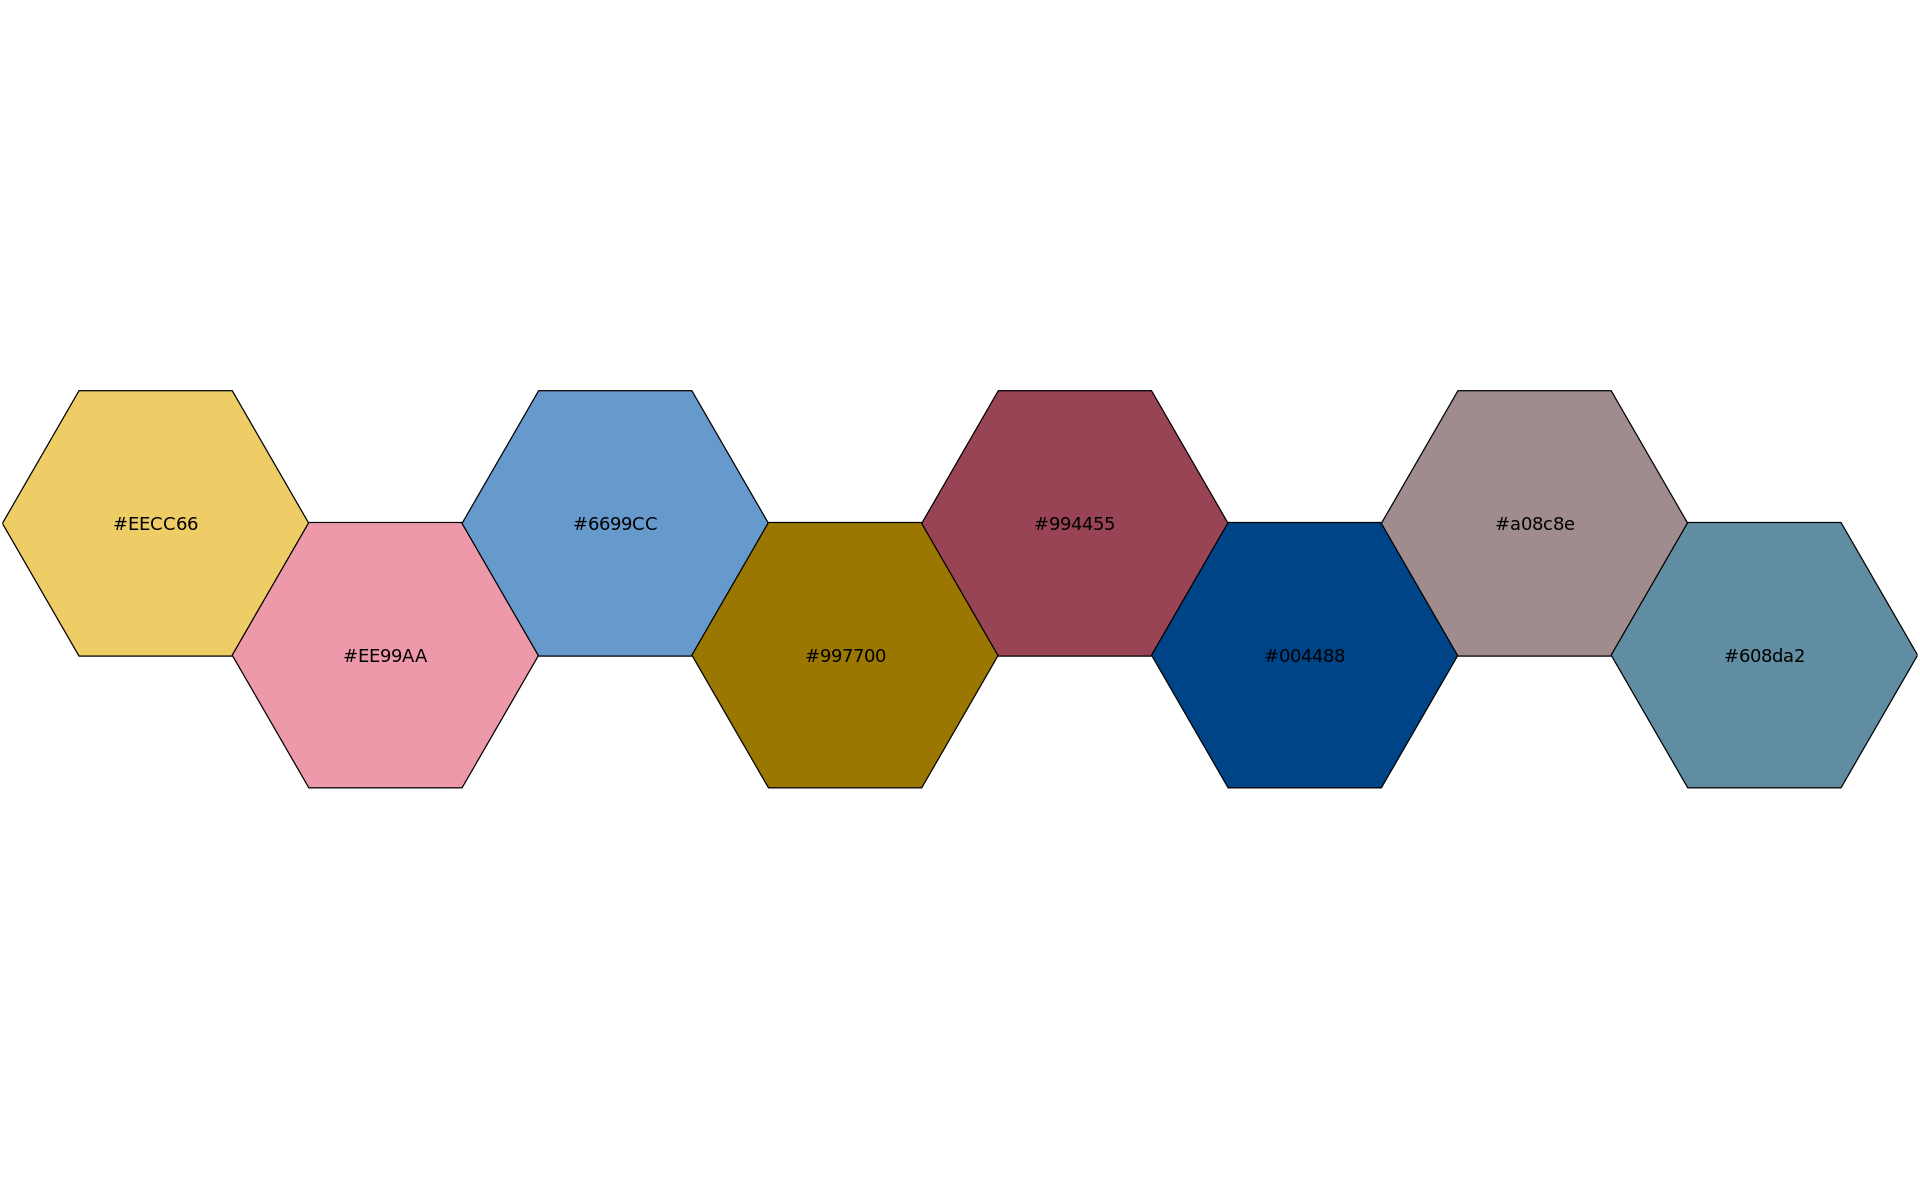

In [2]:
f_func <- "../functions.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_func, '--to=script', '--stdout'), stdout = TRUE)))
f_path <- "../dirs.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_path, '--to=script', '--stdout'), stdout = TRUE)))
f_cols <- "../cols.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_cols, '--to=script', '--stdout'), stdout = TRUE)))

In [3]:
Asp_species_RPM <- readRDS(paste0(INT_SPL, "Asp_species_RPM.Rdata"))

In [4]:
standard_diagnostics <- read.csv(file = "../resources/IPA_standard_diagnostics.csv", header = TRUE, sep =",") %>% 
    as.data.frame() %>% 
    separate(BAL_GM, into = c("BAL_GM_low", "BAL_GM_high"), sep = "-") %>% 
    mutate(BAL_GM_low = as.numeric(BAL_GM_low)) %>% 
    mutate(BAL_GM_high = as.numeric(BAL_GM_high)) %>% 
    rename(PCR_aspergillus = "BAL_PCR_aspergillus") %>% 
    mutate(BAL_PCR_aspergillus = tolower(BAL_PCR_aspergillus)) %>% 
    mutate(BAL_Kweek_in_BAL = tolower(BAL_Kweek_in_BAL)) %>% 
    mutate(BAL_Kweek_in_BAL = ifelse(BAL_Kweek_in_BAL == "a. fumigatus", yes = "pos", no = BAL_Kweek_in_BAL)) %>% 
    mutate(BAL_Kweek_in_BAL = ifelse(BAL_Kweek_in_BAL == "no", yes = "neg", no = BAL_Kweek_in_BAL))

standard_diagnostics_serum <-  standard_diagnostics %>% select(c("sample_short", "serum_GM"))
standard_diagnostics_BAL <-  standard_diagnostics %>% select(-c("serum_GM"))

Asp_species_RPM_BAL <- Asp_species_RPM %>% 
        filter(grepl(threshold, pattern = str_extract(0.4, pattern = "[0-9].[0-9]"))) %>% 
        filter(taxName == "Aspergillus fumigatus") %>% 
        melt(varnames = c("db", "sample"), id.vars = c("taxName", "db", "threshold", "sample"), value.name = "value") %>%  
        mutate(sample_short = str_sub(sample, 1, 3)) %>% 
        filter(grepl(sample, pattern = "asp$")) %>% 
        filter(db == "EPRSc2") %>% 
        mutate(sample = ifelse(grepl(sample, pattern = "[0-9]B[a-z]"), yes = "BAL", 
                ifelse(grepl(sample, pattern = "[0-9]P[a-z]"), yes = "plasma", no = "control"))) %>% 
        filter(sample_short %nin% c("A11", "A12", "A13", "A16")) %>% 
        mutate(value = value*10^6) %>% 
        mutate(RPM = "fractional abundance") %>% 
        mutate(origin = ifelse(sample == "plasma", yes = "Plasma ss-cfDNA",
                        ifelse(sample == "BAL", yes = "BAL ss-cfDNA", no = NA))) %>% 
        filter(origin == "BAL ss-cfDNA")

Asp_species_RPM_plasma <- Asp_species_RPM %>% 
        filter(grepl(threshold, pattern = str_extract(0.4, pattern = "[0-9].[0-9]"))) %>% 
        filter(taxName == "Aspergillus fumigatus") %>% 
        melt(varnames = c("db", "sample"), id.vars = c("taxName", "db", "threshold", "sample"), value.name = "value") %>%  
        mutate(sample_short = str_sub(sample, 1, 3)) %>% 
        filter(grepl(sample, pattern = "asp$")) %>% 
        filter(db == "EPRSc2") %>% 
        mutate(sample = ifelse(grepl(sample, pattern = "[0-9]B[a-z]"), yes = "BAL", 
                ifelse(grepl(sample, pattern = "[0-9]P[a-z]"), yes = "plasma", no = "control"))) %>% 
        filter(sample_short %nin% c("A11", "A12", "A13", "A16")) %>% 
        mutate(value = value*10^6) %>% 
        mutate(RPM = "fractional abundance") %>% 
        mutate(origin = ifelse(sample == "plasma", yes = "Plasma ss-cfDNA",
                        ifelse(sample == "BAL", yes = "BAL ss-cfDNA", no = NA))) %>% 
        filter(origin == "Plasma ss-cfDNA")

BAL_merged <- merge(Asp_species_RPM_BAL, standard_diagnostics_BAL, by = "sample_short") 
blood_merged <- merge(Asp_species_RPM_plasma, standard_diagnostics_serum, by = "sample_short")

In [5]:
blood_based <- blood_merged %>% 
    ggplot(aes(y = value, x = serum_GM)) + 
    geom_point(aes(color = sample_short, shape = origin), size = 4, alpha = 0.5) + 
    scale_color_manual(values = alpha(c(colors_mc), alpha = 0.8), na.value = NA, na.translate=FALSE) + 
    scale_shape_manual(values = c(16)) + 
    labs(y = "plasma A. fumigatus RPM", 
         x = "serum GM") +  
    theme_bw() + stat_cor(method = "pearson", size = 6, label.x.npc = "middle") + 
        guides(color = "none") + 
        labs(color = NULL, shape = NULL)

BAL_based1 <- BAL_merged %>% 
    ggplot(aes(y = value, x = BAL_GM_low)) + 
    geom_point(aes(color = sample_short, shape = origin), size = 4, alpha = 0.5) + 
    scale_color_manual(values = alpha(c(colors_mc), alpha = 0.8), na.value = NA, na.translate=FALSE) + 
    scale_shape_manual(values = c(17)) + 
    labs(y = "BAL A. fumigatus RPM", 
         x = "BAL min. GM") +  
    theme_bw() + stat_cor(method = "pearson", size = 6, label.x.npc = "middle") + 
        labs(color = NULL, shape = NULL)

BAL_based2 <- BAL_merged %>% 
    ggplot(aes(y = value, x = BAL_GM_high)) + 
    geom_point(aes(color = sample_short, shape = origin), size = 4, alpha = 0.5) + 
    scale_color_manual(values = alpha(c(colors_mc), alpha = 0.8), na.value = NA, na.translate=FALSE) + 
    scale_shape_manual(values = c(17)) + 
    labs(y = "BAL A. fumigatus RPM", 
         x = "BAL max. GM") +  
    theme_bw() + stat_cor(method = "pearson", size = 6, label.x.npc = "middle") + 
        labs(color = NULL, shape = NULL)

BAL_based3 <- BAL_merged %>% 
    ggplot(aes(y = value, x = BAL_PCR_aspergillus)) + 
    geom_point(aes(color = sample_short, shape = origin), size = 4, alpha = 0.5) + 
    scale_color_manual(values = alpha(c(colors_mc), alpha = 0.8), na.value = NA, na.translate=FALSE) + 
    scale_shape_manual(values = c(17)) + 
    theme_bw() + 
    labs(x = "BAL PCR", 
         y = "BAL A. fumigatus RPM") + 
        labs(color = NULL, shape = NULL)

BAL_based4 <- BAL_merged %>% 
    ggplot(aes(y = value, x = BAL_Kweek_in_BAL)) + 
    geom_point(aes(color = sample_short, shape = origin), size = 4, alpha = 0.5) + 
    scale_color_manual(values = alpha(c(colors_mc), alpha = 0.8), na.value = NA, na.translate=FALSE) + 
    scale_shape_manual(values = c(17)) + 
    theme_bw() + 
    labs(x = "BAL A. fumigatus culture", 
         y = "BAL A. fumigatus RPM") + 
        labs(color = NULL, shape = NULL)

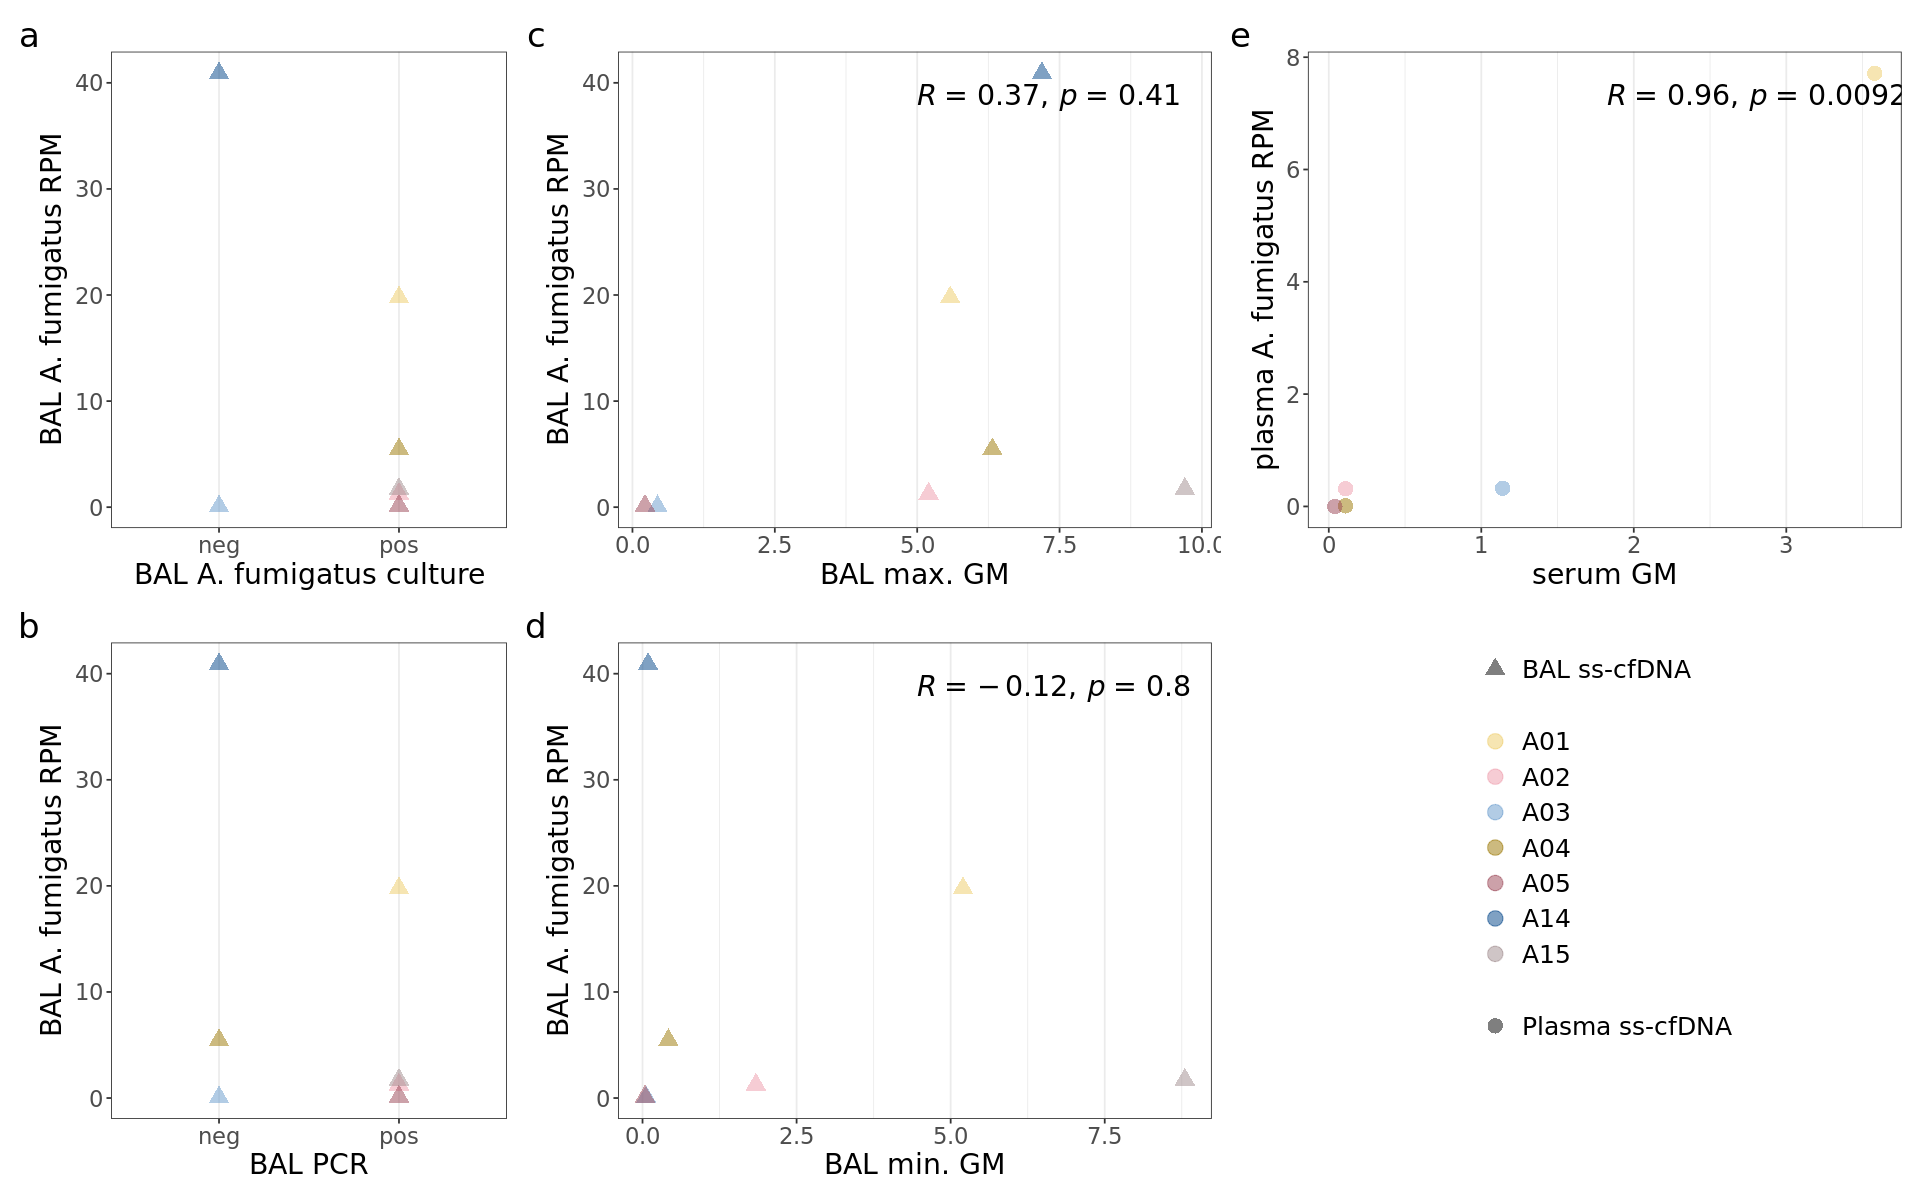

In [6]:
options(repr.plot.width=16, repr.plot.height=10) 
layout <- "ACE
           BDF"
SuplFig13 <- BAL_based4 + BAL_based3 + BAL_based2 + BAL_based1 + blood_based + guide_area() +
    plot_layout(ncol = 2, design = layout, widths = c(2,3,3), guides = "collect") &
        plot_annotation(tag_levels = 'a') &
        theme(legend.position='right', legend.justification='top', legend.direction = 'vertical',
            legend.key.size = unit(0.75, 'cm'), legend.key.height = unit(0.75, 'cm'), legend.key.width = unit(0.75, 'cm'), 
            text = element_text(size = 17), legend.text = element_text(size = 15, colour = "black"),
            plot.title = element_text(size = 20, hjust = 0.5, face = "bold"), 
            plot.subtitle = element_text(size = 17, hjust = 0.5),
            strip.background=element_rect(fill="white", color = "white"), 
            panel.grid.minor.y = element_blank(), panel.grid.major.y = element_blank()) 

SuplFig13

ggsave("../../output/suppl_figures/SuplFig13_R.png", 
       SuplFig13, width = 20, height = 10)
ggsave("../../output/suppl_figures/SuplFig13_R.pdf", 
       SuplFig13, width = 20, height = 10)